# 一、前期工作

本项目采用CNN卷积神经网络实现多云、下雨、晴、日出四种天气状态的识别。

## 1. 设置GPU
如果存在GPU，则使用GPU，否则使用CPU

In [1]:
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
    gpu0 = gpus[0]                                        #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True)  #设置GPU显存用量按需使用
    tf.config.set_visible_devices([gpu0],"GPU")
gpus

[]

## 2. 导入数据

In [3]:
import matplotlib.pyplot as plt
import os,PIL

# 设置随机种子尽可能使结果可以重现
import numpy as np
np.random.seed(1)

# 设置随机种子尽可能使结果可以重现
import tensorflow as tf
tf.random.set_seed(1)

from tensorflow import keras
from tensorflow.keras import layers,models

import pathlib

In [4]:
data_dir = "./weather_photos/"

data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('weather_photos')

## 3. 查看数据

数据集一共分为`cloudy`、`rain`、`shine`、`sunrise`四类，分别存放于`weather_photos`文件夹中以各自名字命名的子文件夹中。

In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))

print("图片总数为：",image_count)

图片总数为： 1125


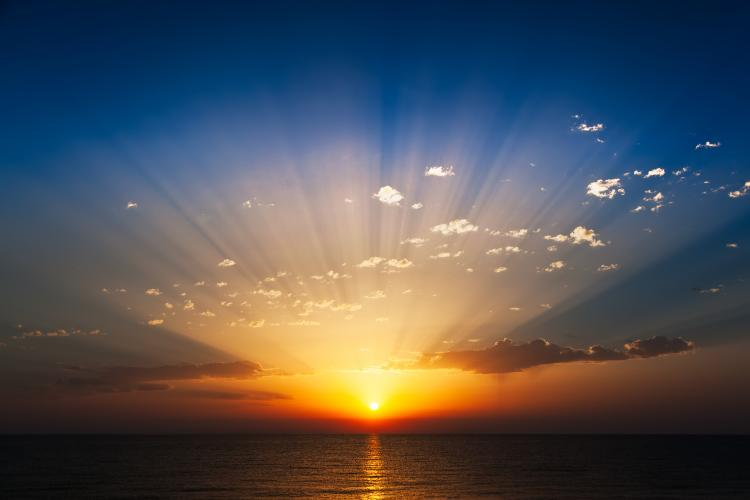

In [6]:
roses = list(data_dir.glob('sunrise/*.jpg'))
PIL.Image.open(str(roses[0]))

# 二、数据预处理

## 1. 加载数据

使用`image_dataset_from_directory`方法将磁盘中的数据加载到`tf.data.Dataset`中

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 900 files for training.


In [9]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1125 files belonging to 4 classes.
Using 225 files for validation.


我们可以通过class_names输出数据集的标签。标签将按字母顺序对应于目录名称。

In [10]:
class_names = train_ds.class_names
print(class_names)

['cloudy', 'rain', 'shine', 'sunrise']


## 2. 可视化数据

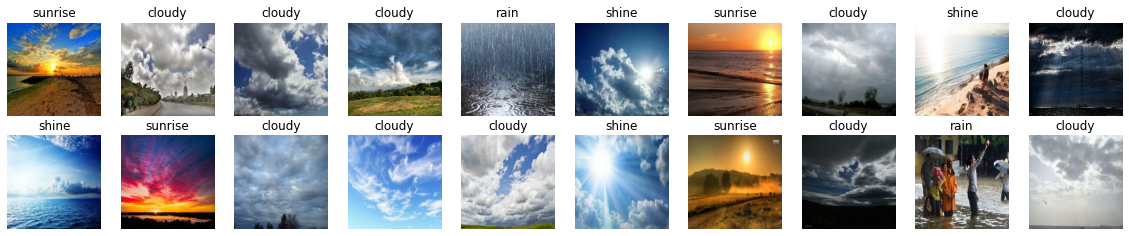

In [11]:
plt.figure(figsize=(20, 10))

for images, labels in train_ds.take(1):
    for i in range(20):
        ax = plt.subplot(5, 10, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        
        plt.axis("off")

## 3. 再次检查数据 

In [12]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


- `Image_batch`是形状的张量（32,180,180,3）。这是一批形状180x180x3的32张图片（最后一维指的是彩色通道RGB）。 
- `Label_batch`是形状（32，）的张量，这些标签对应32张图片

## 4. 配置数据集

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 三、构建CNN网络

In [14]:
num_classes = 4



model = models.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)), # 卷积层1，卷积核3*3  
    layers.AveragePooling2D((2, 2)),               # 池化层1，2*2采样
    layers.Conv2D(32, (3, 3), activation='relu'),  # 卷积层2，卷积核3*3
    layers.AveragePooling2D((2, 2)),               # 池化层2，2*2采样
    layers.Conv2D(64, (3, 3), activation='relu'),  # 卷积层3，卷积核3*3
    layers.Dropout(0.3),  
    
    layers.Flatten(),                       # Flatten层，连接卷积层与全连接层
    layers.Dense(128, activation='relu'),   # 全连接层，特征进一步提取
    layers.Dense(num_classes)               # 输出层，输出预期结果
])

model.summary()  # 打印网络结构

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 average_pooling2d (AverageP  (None, 89, 89, 16)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 average_pooling2d_1 (Averag  (None, 43, 43, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

# 四、编译

在准备对模型进行训练之前，还需要再对其进行一些设置。以下内容是在模型的编译步骤中添加的：

- 损失函数（loss）：用于衡量模型在训练期间的准确率。
- 优化器（optimizer）：决定模型如何根据其看到的数据和自身的损失函数进行更新。
- 指标（metrics）：用于监控训练和测试步骤。以下示例使用了准确率，即被正确分类的图像的比率。

In [16]:
# 设置优化器
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 五、训练模型

In [17]:
epochs = 10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
29/29 [==============================] - 14s 339ms/step - loss: 1.1430 - accuracy: 0.5500 - val_loss: 0.5891 - val_accuracy: 0.7733
Epoch 2/10
29/29 [==============================] - 9s 309ms/step - loss: 0.5531 - accuracy: 0.7944 - val_loss: 0.5969 - val_accuracy: 0.7422
Epoch 3/10
29/29 [==============================] - 9s 301ms/step - loss: 0.4164 - accuracy: 0.8456 - val_loss: 0.5289 - val_accuracy: 0.7644
Epoch 4/10
29/29 [==============================] - 9s 304ms/step - loss: 0.3345 - accuracy: 0.8756 - val_loss: 0.5336 - val_accuracy: 0.7822
Epoch 5/10
29/29 [==============================] - 9s 306ms/step - loss: 0.2772 - accuracy: 0.8922 - val_loss: 0.5007 - val_accuracy: 0.8133
Epoch 6/10
29/29 [==============================] - 9s 294ms/step - loss: 0.1954 - accuracy: 0.9333 - val_loss: 0.4737 - val_accuracy: 0.8044
Epoch 7/10
29/29 [==============================] - 9s 299ms/step - loss: 0.1545 - accuracy: 0.9444 - val_loss: 0.4110 - val_accuracy: 0.8356
Epoch

In [18]:
# 保存模型
model.save("weather_model.h5")

# 六、模型评估

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

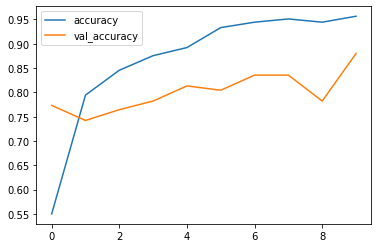

In [21]:
plt.plot(history.epoch, history.history.get('accuracy'), label='accuracy')
plt.plot(history.epoch, history.history.get('val_accuracy'), label='val_accuracy')
plt.legend()

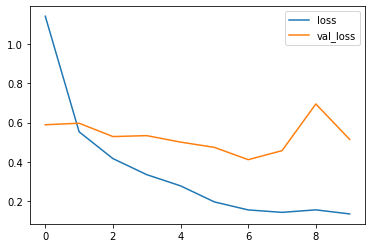

In [22]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

# 七、预测

In [31]:
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [180, 180])
    image = tf.cast(image, tf.float32)
#     image = image/255.0  # normalize to [0,1] range
    return image

test_img = './weather_photos/sunrise/sunrise1.jpg'
test_tensor = load_and_preprocess_image(test_img)
test_tensor = tf.expand_dims(test_tensor, axis=0)
pred = model.predict(test_tensor)
np.argmax(pred)

3